In [3]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image

plt.style.use('ggplot')

In [4]:
annot = pd.read_parquet('../dataset/ocr_dataset/annot.parquet')
imgs = pd.read_parquet('../dataset/ocr_dataset/img.parquet')
img_fns = glob('../dataset/ocr_dataset/train_val_images/train_images/*')

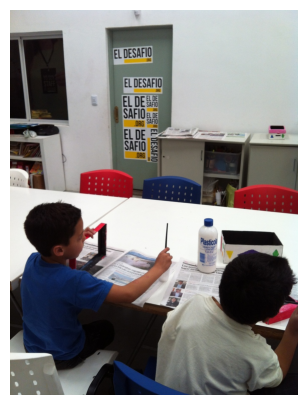

In [5]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(plt.imread(img_fns[1]))
ax.axis('off')
plt.show()

In [6]:
image_id = img_fns[0].split('/')[-1].split('.')[0]
annot.query('image_id == @image_id')

,id,image_id,bbox,utf8_string,points,area
470238,55e117b610794104_1,55e117b610794104,"[601.82, 261.42, 311.04, 128.86]",KFC®,"[601.82, 286.3, 902.19, 261.42, 912.86, 363.62...",40080.61
470239,55e117b610794104_2,55e117b610794104,"[482.47, 537.9, 37.77, 22.97]",TM,"[482.47, 537.9, 518.2, 542.49, 520.24, 560.87,...",867.58
470240,55e117b610794104_3,55e117b610794104,"[309.4, 683.62, 252.7, 110.81]",Drive,"[334.61, 683.62, 562.1, 708.83, 550.96, 794.43...",28001.69
470241,55e117b610794104_4,55e117b610794104,"[566.25, 717.18, 205.18, 100.05]",Thru,"[577.99, 717.18, 771.43, 745.26, 761.23, 817.2...",20528.26


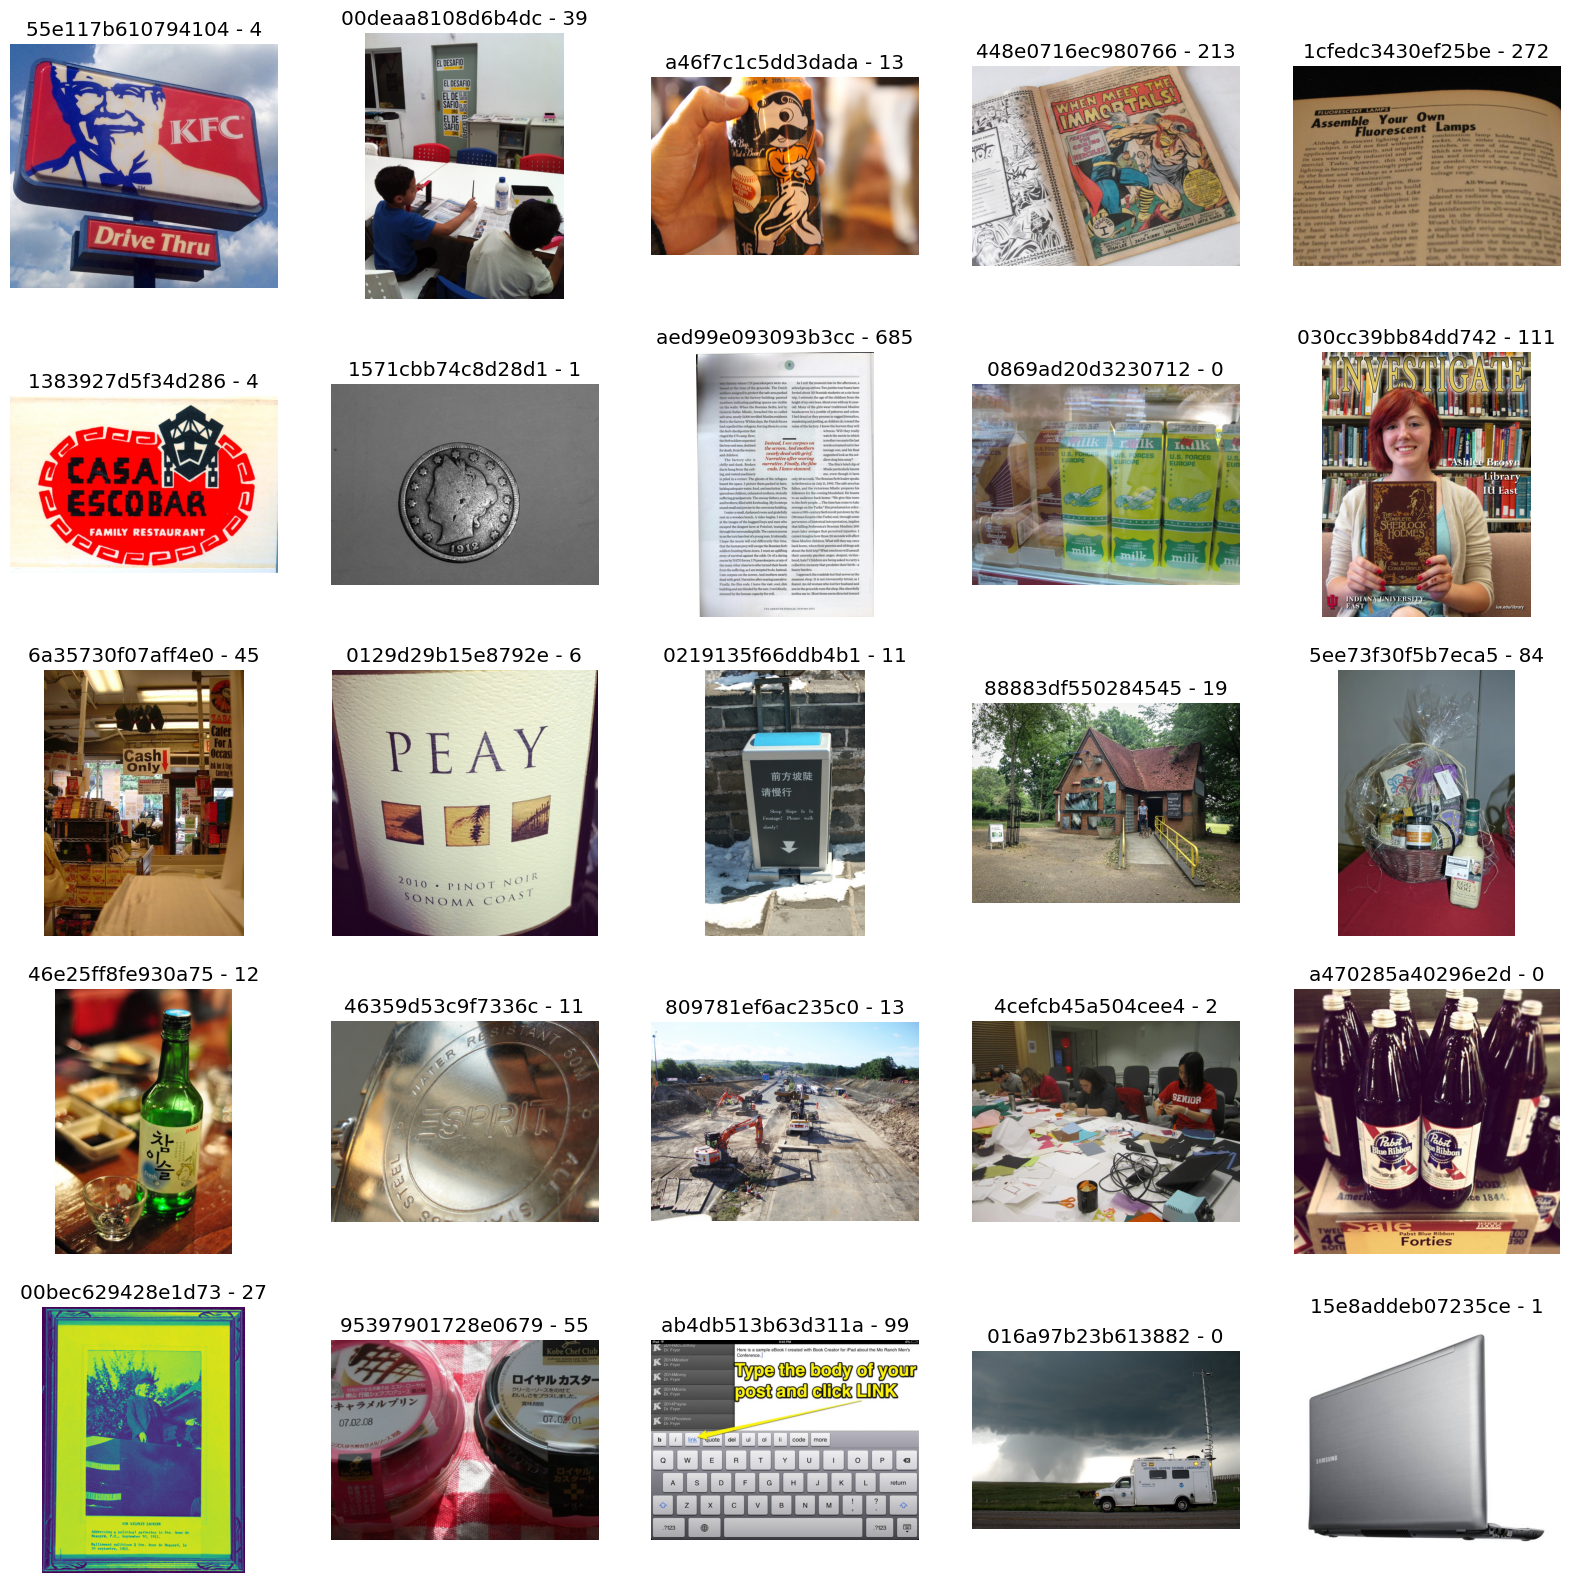

In [7]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
axs = axs.flatten()
for i in range(25):
    axs[i].imshow(plt.imread(img_fns[i]))
    axs[i].axis('off')
    image_id = img_fns[i].split('/')[-1].rstrip('.jpg')
    n_annot = len(annot.query('image_id == @image_id'))
    axs[i].set_title(f'{image_id} - {n_annot}')
plt.show()

In [8]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch

# Load pretrained TrOCR model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")

# Move to M4 Pro (Apple Silicon supports Metal backend)
device = "mps" if torch.backends.mps.is_available() else "cpu"
model.to(device)


/Users/meet4224/VS CODE/OCRNet/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (i

In [13]:
# Load your test image
image_path = "../images/00a0db6495982c1d.jpg"
image = Image.open(image_path).convert("RGB")

# Preprocess
pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

# Run inference
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("Predicted text:", generated_text)


Predicted text: KEYBANK OR


In [22]:
import os
from PIL import Image

# Path to dataset folder
dataset_path = "../dataset/ocr_dataset/train_val_images/train_images"

print("Dataset found at:", dataset_path)

# Get list of images
image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
print(f"Total images found: {len(image_files)}")

# Process first 50 images (or fewer if dataset has < 50)
for idx, img_name in enumerate(image_files[:5]):
    img_path = os.path.join(dataset_path, img_name)
    print(f"\n[{idx+1}] Processing {img_name}...")

    try:
        # Load image
        image = Image.open(img_path).convert("RGB")
        print(f"   ✅ Loaded image: {img_path}")

        # Preprocess
        pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
        print("   ✅ Preprocessing done")

        # Run inference
        generated_ids = model.generate(pixel_values)
        text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        print(f"   ✅ Prediction: {text}")

    except Exception as e:
        print(f"   ❌ Error processing {img_name}: {str(e)}")


Dataset found at: ../dataset/ocr_dataset/train_val_images/train_images
Total images found: 18923

[1] Processing 55e117b610794104.jpg...
   ✅ Loaded image: ../dataset/ocr_dataset/train_val_images/train_images/55e117b610794104.jpg
   ✅ Preprocessing done
   ✅ Prediction: ITEM

[2] Processing 00deaa8108d6b4dc.jpg...
   ✅ Loaded image: ../dataset/ocr_dataset/train_val_images/train_images/00deaa8108d6b4dc.jpg
   ✅ Preprocessing done
   ✅ Prediction: L

[3] Processing a46f7c1c5dd3dada.jpg...
   ✅ Loaded image: ../dataset/ocr_dataset/train_val_images/train_images/a46f7c1c5dd3dada.jpg
   ✅ Preprocessing done
   ✅ Prediction: CAX

[4] Processing 448e0716ec980766.jpg...
   ✅ Loaded image: ../dataset/ocr_dataset/train_val_images/train_images/448e0716ec980766.jpg
   ✅ Preprocessing done
   ✅ Prediction: TAX

[5] Processing 1cfedc3430ef25be.jpg...
   ✅ Loaded image: ../dataset/ocr_dataset/train_val_images/train_images/1cfedc3430ef25be.jpg
   ✅ Preprocessing done
   ✅ Prediction: OFF)


# Final Output